# ARMAX Example

This notebook demonstrates the ARMAX model identification and validation process.

In [1]:
import control.matlab as cnt
import numpy as np
from utils import (
    W_V,
    plot_bode,
    plot_response,
    plot_responses,
)

from sippy_unipi import system_identification
from sippy_unipi.datasets import gen_gbn_seq, load_sample_siso, white_noise_var
from sippy_unipi.evaluate import validation

np.random.seed(0)

## Load Sample Data

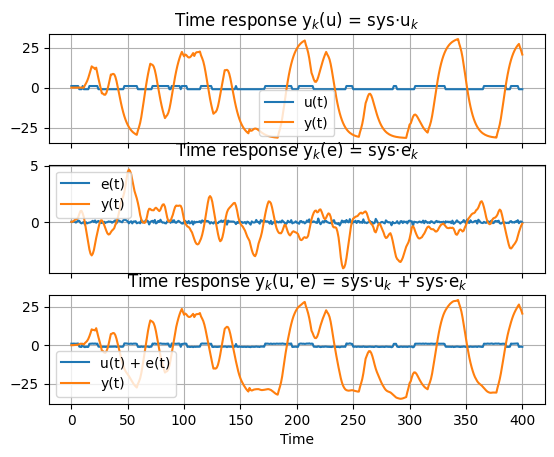

In [2]:
ylegends = ["System", "ARMAX-I", "ARMAX-0", "ARMAX-R"]
n_samples = 401
ts = 1.0
time, Ysim, Usim, g_sys, Yerr, Uerr, h_sys, Ytot, Utot = load_sample_siso(
    n_samples, ts, seed=0
)

fig = plot_responses(
    time,
    [Usim, Uerr, Utot],
    [Ysim, Yerr, Ytot],
    ["u", "e", ["u", "e"]],
)

## System Identification

In [3]:
mode = "FIXED"

if mode == "IC":
    na_ord = [4, 4]
    nb_ord = [3, 3]
    nc_ord = [2, 2]
    theta = [11, 11]
else:
    na_ord = [4]
    nb_ord = [[3]]
    nc_ord = [2]
    theta = [[11]]

identification_params = [
    ((na_ord, nb_ord, nc_ord, theta), {"IC": "BIC", "id_mode": "ILLS"}),
    ((na_ord, nb_ord, nc_ord, theta), {"IC": "BIC", "id_mode": "OPT"}),
    ((na_ord, nb_ord, nc_ord, theta), {"IC": "BIC", "id_mode": "RLLS"}),
]

syss = []
for orders_params in identification_params:
    orders, params = orders_params
    sys_id = system_identification(
        Ytot, Usim, "ARMAX", *orders, ts=ts, max_iter=300, **params
    )
    syss.append(sys_id)

ys = [Ytot] + [getattr(sys, "y_id").T for sys in syss]

/app/sippy_unipi/identification.py:99: UserWarning: Ignoring argument 'IC' as fixed orders are provided.
  warn("Ignoring argument 'IC' as fixed orders are provided.")


## Check Consistency of the Identified System

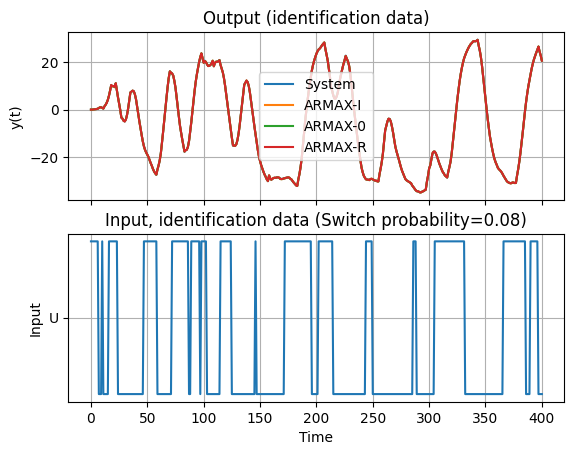

In [4]:
fig = plot_response(
    time,
    ys,
    Usim,
    legends=[ylegends, ["U"]],
    titles=[
        "Output (identification data)",
        "Input, identification data (Switch probability=0.08)",
    ],
)

## Validation of the Identified System

/opt/pysetup/.venv/lib/python3.12/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


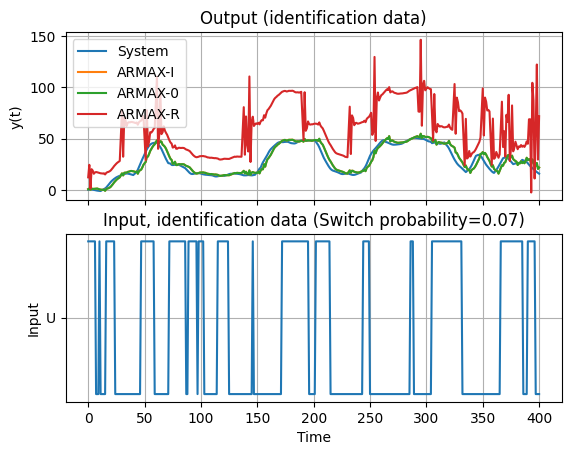

In [5]:
switch_probability = 0.07
input_range = (0.5, 1.5)
[U_valid, _, _] = gen_gbn_seq(n_samples, switch_probability, scale=input_range)
white_noise_variance = [0.01]
e_valid = white_noise_var(U_valid.size, white_noise_variance)[0]

Yvalid1, time, Xsim = cnt.lsim(g_sys, U_valid, time)
Yvalid2, time, Xsim = cnt.lsim(h_sys, e_valid, time)
Ytotvalid = Yvalid1 + Yvalid2

ys = [Ytotvalid] + [validation(sys, U_valid, Ytotvalid, time) for sys in syss]

fig = plot_response(
    time,
    ys,
    Usim,
    legends=[ylegends, ["U"]],
    titles=[
        "Output (identification data)",
        "Input, identification data (Switch probability=0.07)",
    ],
)

## Compute RMSE and Explained Variance

In [6]:
for y, sys in zip(ys, syss):
    yv = y.T
    rmse = np.round(np.sqrt(np.mean((Ytotvalid - yv) ** 2)), 2)
    EV = 100.0 * (
        np.round((1.0 - np.mean((Ytotvalid - yv) ** 2) / np.std(Ytotvalid)), 2)
    )
    print(f"RMSE = {rmse}")
    print(f"Explained Variance = {EV}%")

RMSE = 0.0
Explained Variance = 100.0%
RMSE = 20.31
Explained Variance = -2805.0%
RMSE = 20.3
Explained Variance = -2804.0%


## Step Tests

/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: Fu

/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: Fu

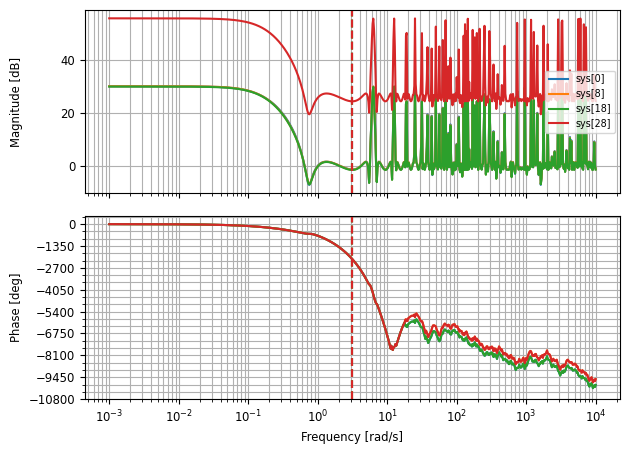

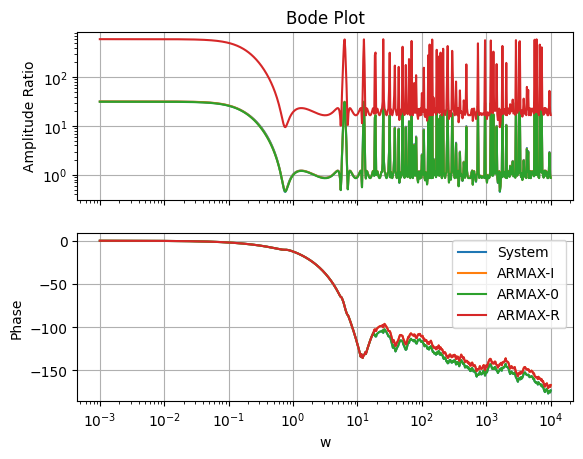

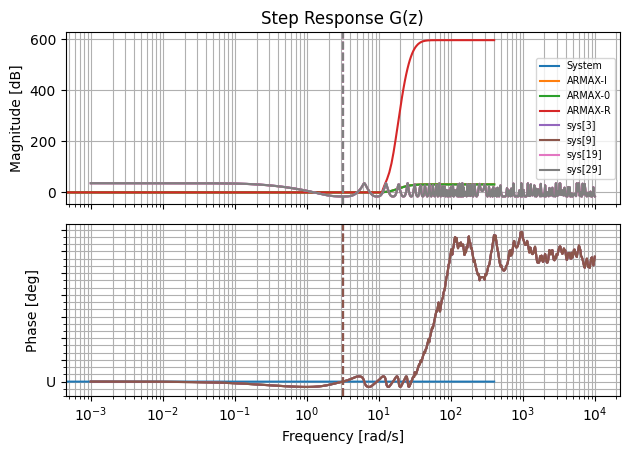

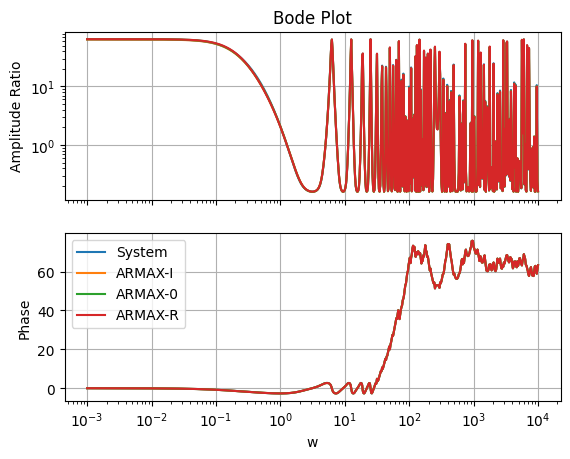

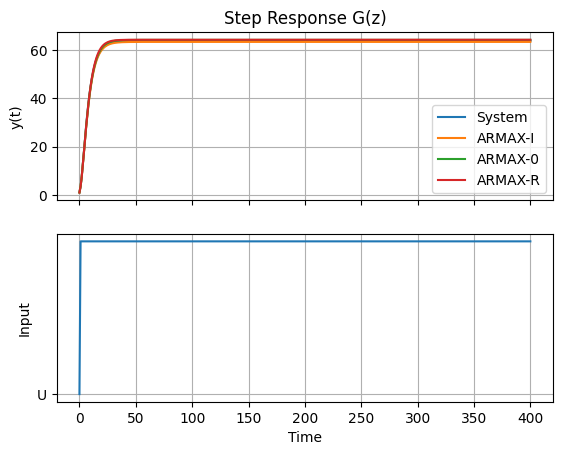

In [7]:
u = np.ones_like(time)
u[0] = 0

for tf in ["G", "H"]:
    syss_tfs = [
        locals()[f"{tf.lower()}_sys"],
        *[getattr(sys, tf) for sys in syss],
    ]
    mags, fis, oms = zip(*[cnt.bode(sys, W_V) for sys in syss_tfs])

    fig = plot_bode(
        oms[0],
        mags,
        fis,
        ylegends,
    )

    ys, _ = zip(*[cnt.step(sys, time) for sys in syss_tfs])

    fig = plot_response(
        time,
        ys,
        u,
        legends=[ylegends, ["U"]],
        titles=["Step Response G(z)", None],
    )